In [41]:
import os
import cv2
import random
import imutils
import numpy as np
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR
from tensorflow.keras.preprocessing import image as tfimage
from trdg.generators import GeneratorFromStrings


In [46]:
ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
DATASET_PATH = f'dataset'

# type decls
cv2.Image = np.ndarray

# shows an image on ipynb
def imshow(img: cv2.Image) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Get all testing images into an array

In [47]:
images = []
for (id, filename) in enumerate(os.listdir(DATASET_PATH)):
    image = cv2.imread(f"{DATASET_PATH}/{filename}")
    images.append((filename, image))

Defines image cropper to center the text in the image

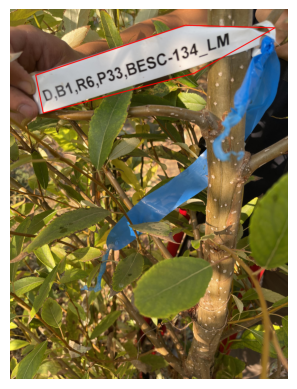

71.48042297363281


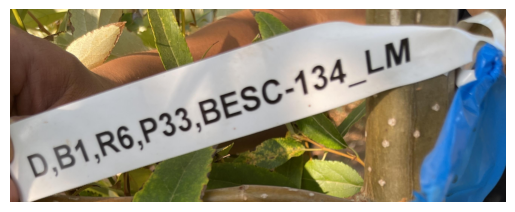

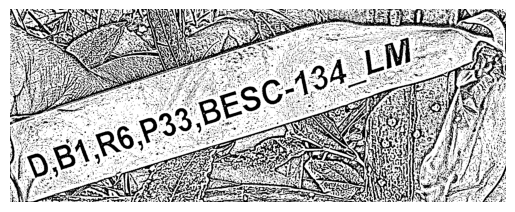

In [51]:
def process_image(img: cv2.Image) -> cv2.Image:
    gray = grayscale(img)
    blur = cv2.medianBlur(gray, 5)
    blur = tfimage.img_to_array(blur, dtype='uint8')
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 0.5)
    return thresh

def crop_image(img: cv2.Image, debug: bool = False) -> cv2.Image:

    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur,150,255,0)[1]
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

    big_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    approx = cv2.approxPolyDP(big_contour, 0.025*cv2.arcLength(big_contour, True), True)

    if debug:
        drawn_contours = cv2.drawContours(img.copy(), [approx], -1, (0, 0, 255), 10)
        imshow(drawn_contours)

    x, y, w, h = cv2.boundingRect(big_contour)
    newimg = img[y:y+h, x:x+w]
    angle = cv2.minAreaRect(approx)[-1]

    if h > w:
        # TODO: perform image rotation
        pass

    if debug: 
        print(angle)
        imshow(newimg)
        
    # newimg = imutils.rotate(newimg, angle=-angle)

    return newimg

test_index = 5
img = crop_image(images[test_index][1], debug=True)
img = process_image(img)
imshow(img)

Generate synthetic data to train neural network

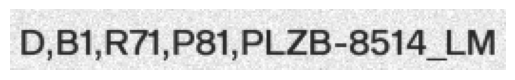

In [49]:
ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
IMG_COUNT = 100
DATA_PATH = 'synthetic-data'
IMAGES_PATH = f'{DATA_PATH}/images'

os.system(f"{'rm -rf' if os.name != 'nt' else 'rmdir /s /q'} {DATA_PATH}")
os.system(f"mkdir {DATA_PATH} {IMAGES_PATH}")
os.system(f"echo '*' > {DATA_PATH}/.gitignore")

def get_random_text():
    treatment = random.choice(['C', 'D'])
    block = f"B{random.choice(['1', '2'])}"
    row = f"R{random.randint(1, 99)}"
    position = f"P{random.randint(1, 99)}"
    
    gen_length = random.randint(2, 4)
    num_count = random.choices([1, 2, 3], weights=(70, 15, 15))[0]
    num_lengths = random.choices([1, 2, 3, 4], weights=(15, 15, 15, 55), k=num_count)

    genotype = (
        "".join([ALPHABET[random.randint(0, 25)] for _ in range(gen_length)]) + 
        f"-{'-'.join([str(random.randint(10**(i-1), 10**i-1)) for i in num_lengths])}_LM"
    )

    return ','.join([treatment, block, row, position, genotype])

# generate the new images, limiting count
generator = GeneratorFromStrings(
    [get_random_text() for _ in range(1000)],
    random_blur=True,
    random_skew=True,
    fonts=['image_font.ttf']
)
i = 0
for img, lbl in generator:
    if i == IMG_COUNT: break
    img.save(f'{IMAGES_PATH}/{lbl}_{i}.png')
    i += 1

# randomly selects one image for exemplary purposes
example_img = random.choice(os.listdir(IMAGES_PATH))
imshow(cv2.imread(f"{IMAGES_PATH}/{example_img}"))

[2023/06/30 13:46:05] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[]]


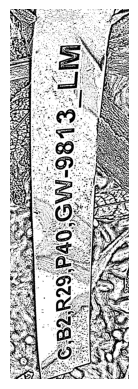

[2023/06/30 13:46:05] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[132.0, 186.0], [1665.0, 127.0], [1669.0, 222.0], [136.0, 281.0]], ('G B1 R8 P6 BESC 415 LM', 0.8378536701202393)]]]


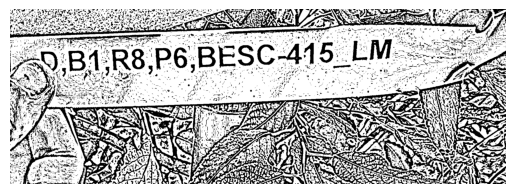

[2023/06/30 13:46:06] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[196.0, 250.0], [2132.0, 79.0], [2142.0, 203.0], [206.0, 374.0]], ('C B1R3P31**BESCA50LM', 0.8948461413383484)]]]


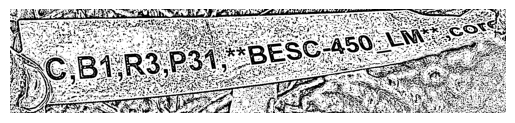

[2023/06/30 13:46:06] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[]]


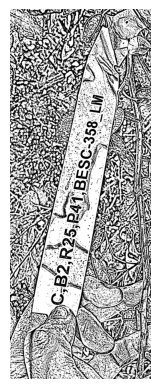

[2023/06/30 13:46:07] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[188.0, 464.0], [1516.0, 263.0], [1532.0, 359.0], [204.0, 559.0]], ('B1 R6 P10.GW-9847 LM', 0.9156914949417114)]]]


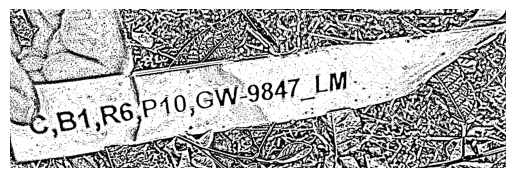

[2023/06/30 13:46:07] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[70.0, 754.0], [2115.0, 129.0], [2164.0, 281.0], [119.0, 906.0]], ('D.B1 R6.P33.BESC-134 LM', 0.9116458296775818)]]]


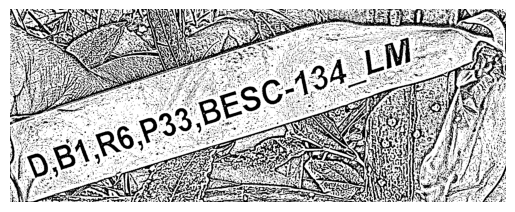

[2023/06/30 13:46:07] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[]]


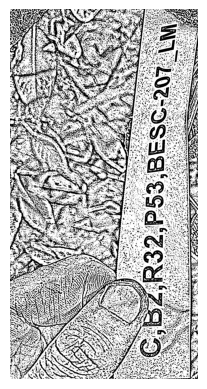

[2023/06/30 13:46:08] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[]]


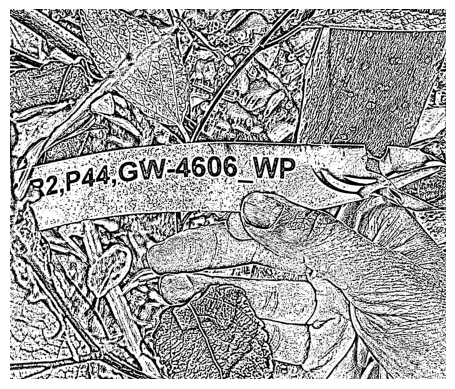

[2023/06/30 13:46:09] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[578.0, 1371.0], [657.0, 1371.0], [657.0, 1460.0], [578.0, 1460.0]], ('3', 0.8400517702102661)]]]


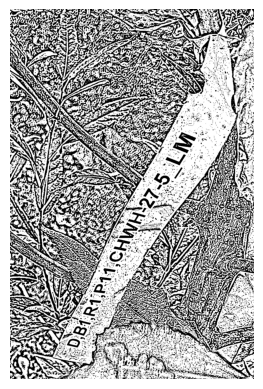

In [54]:
OCR = PaddleOCR(user_angle_cls=True, lang='en', show_log=False, rotation=True)
filtered_images = map(lambda x: process_image(crop_image(x[1])), images)
for image in filtered_images:
    print(OCR.ocr(image))
    imshow(image)